# Level 3: ILP (Integer Linear Programming) Optimal GHZ Path

**Approach:** Formulate the GHZ chain mapping as an Integer Linear Program
to find the **provably optimal** linear chain on the hardware.

**Variables:** $x_{i,k} \in \{0,1\}$: hardware qubit $i$ is at position $k$ in the chain.

**Constraints:**
- One qubit per position: $\sum_i x_{i,k} = 1$ for each $k$
- Use each qubit at most once: $\sum_k x_{i,k} \leq 1$ for each $i$
- Connectivity: adjacent positions must be physically connected

**Objective:** Maximize total log-fidelity:
$$\max \sum_{i,k} x_{i,k} \cdot \log F_{RO}(i) + \sum_{i,j,k} y_{i,j,k} \cdot \log F_{CZ}(i,j)$$

where $y_{i,j,k} = x_{i,k} \cdot x_{j,k+1}$ is linearized via auxiliary variables.

In [1]:
# CELL 1: Setup
import sys
import subprocess

major, minor = sys.version_info[:2]
if not (major == 3 and minor >= 11):
    print(f"❌ Python {major}.{minor} - need 3.11+")
    raise SystemExit
print(f"✅ Python {major}.{minor} OK")

pip_ver = subprocess.check_output(["pip", "--version"]).decode().split()[1]
if not pip_ver.startswith("25"):
    !pip install --upgrade pip==25.*
    print("✅ pip 25 installed. RESTART runtime!")
else:
    print("✅ pip OK")

✅ Python 3.12 OK
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 21.5 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
✅ pip 25 installed. RESTART runtime!


In [2]:
# install iqm-client with qrisp extras
!pip install -U "iqm-client>=33.0.1" "qrisp[iqm]"
# used for visualization
!pip install matplotlib networkx networkx pulp highspy

from qrisp.interface import IQMBackend

INFO: pip is looking at multiple versions of opentelemetry-proto to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of opentelemetry-proto to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
INFO: pip is looking at multiple versions of numpy-typing-compat to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 33.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 734.6/734.6 kB 14.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 28.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 8

KeyboardInterrupt: 

In [1]:
# CELL 2: Imports
import math
import time
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt
from qiskit import QuantumCircuit, transpile
from iqm.qiskit_iqm import IQMProvider
import pulp

print("Imports OK")

Imports OK


In [2]:
# CELL 3: Configuration & Connection

API_TOKEN = "Yxt82O2nQ6L2g4RSySBmkJetjVb35KEY+yGsUjsVMDwBnBcGPAh/8KW1ElCHu5OF"  # <-- Replace with your Resonance API token
DEVICE = "emerald"
N_QUBITS = 30
SHOTS = 10000

provider = IQMProvider(
    "https://resonance.meetiqm.com",
    quantum_computer=DEVICE,
    token=API_TOKEN,
)
backend = provider.get_backend()
print(f"Backend: {DEVICE}, Qubits: {backend.num_qubits}")

Backend: emerald, Qubits: 54


In [3]:
# CELL 4: Load Calibration Data from JSON
import json
import re

# Path to calibration file - update if needed
CALIBRATION_FILE = "./2026-01-31T18_28_46.713632Z.json"

def load_calibration(filepath):
    """Load calibration data from IQM quality-metric-set JSON file.

    Extracts:
    - READOUT_P10: P(measure 1 | true 0) = error_0_to_1
    - READOUT_P01: P(measure 0 | true 1) = error_1_to_0
    - CZ_FIDELITY: Two-qubit CZ gate fidelities
    """
    with open(filepath) as f:
        data = json.load(f)

    ro_p10 = {}  # error_0_to_1
    ro_p01 = {}  # error_1_to_0
    cz_fids = {}

    for obs in data['observations']:
        field = obs['dut_field']
        value = obs['value']

        # Readout error_0_to_1 (P(measure 1 | true 0))
        m = re.match(r'metrics\.ssro\.measure\.constant\.(QB\d+)\.error_0_to_1', field)
        if m:
            ro_p10[m.group(1)] = value
            continue

        # Readout error_1_to_0 (P(measure 0 | true 1))
        m = re.match(r'metrics\.ssro\.measure\.constant\.(QB\d+)\.error_1_to_0', field)
        if m:
            ro_p01[m.group(1)] = value
            continue

        # CZ gate fidelity
        m = re.match(r'metrics\.rb\.clifford\.uz_cz\.(QB\d+)__(QB\d+)\.fidelity', field)
        if m:
            key = f'{m.group(1)}__{m.group(2)}'
            cz_fids[key] = value

    return ro_p10, ro_p01, cz_fids

READOUT_P10, READOUT_P01, CZ_FIDELITY = load_calibration(CALIBRATION_FILE)

print(f"Loaded calibration from: {CALIBRATION_FILE}")
print(f"  Readout P10 (error_0_to_1): {len(READOUT_P10)} qubits")
print(f"  Readout P01 (error_1_to_0): {len(READOUT_P01)} qubits")
print(f"  CZ fidelities: {len(CZ_FIDELITY)} edges")

# Show worst qubits and gates
worst_ro = sorted(READOUT_P10.items(), key=lambda x: x[1], reverse=True)[:3]
print(f"\nWorst readout P10: {worst_ro}")
worst_cz = sorted(CZ_FIDELITY.items(), key=lambda x: x[1])[:3]
print(f"Worst CZ gates: {worst_cz}")

Loaded calibration from: ./2026-01-31T18_28_46.713632Z.json
  Readout P10 (error_0_to_1): 54 qubits
  Readout P01 (error_1_to_0): 54 qubits
  CZ fidelities: 82 edges

Worst readout P10: [('QB31', 0.0765), ('QB29', 0.042), ('QB7', 0.032)]
Worst CZ gates: [('QB44__QB50', 0.9086148007977384), ('QB21__QB29', 0.96145586061668), ('QB27__QB28', 0.9621512715504612)]


In [4]:
# CELL 5: Parse noise data

ro_fids = {}
for qb in READOUT_P10:
    idx = int(qb[2:]) - 1
    ro_fids[idx] = 1.0 - (READOUT_P10[qb] + READOUT_P01[qb]) / 2.0

cz_fids = {}
for pair, fid in CZ_FIDELITY.items():
    parts = pair.split('__')
    idx1 = int(parts[0][2:]) - 1
    idx2 = int(parts[1][2:]) - 1
    cz_fids[(idx1, idx2)] = fid
    cz_fids[(idx2, idx1)] = fid

print(f"Parsed: {len(ro_fids)} readout fidelities, {len(cz_fids)} CZ fidelities")

Parsed: 54 readout fidelities, 164 CZ fidelities


In [5]:
# CELL 6: Helper functions

def build_topology_graph(backend):
    G = nx.Graph()
    for i in range(backend.num_qubits):
        G.add_node(i)
    for edge in backend.coupling_map:
        G.add_edge(edge[0], edge[1])
    return G


def create_ghz_circuit(n, basis='Z'):
    qc = QuantumCircuit(n, n)
    qc.h(0)
    for i in range(n - 1):
        qc.cx(i, i + 1)
    if basis == 'X':
        for i in range(n):
            qc.h(i)
    qc.measure_all()
    return qc


def compute_fidelity(counts_z, counts_x, n):
    total_z = sum(counts_z.values())
    p00 = counts_z.get('0' * n, 0) / total_z
    p11 = counts_z.get('1' * n, 0) / total_z
    zz = 2 * (p00 + p11) - 1
    total_x = sum(counts_x.values())
    xx = sum((1 if s.count('1')%2==0 else -1) * c/total_x for s, c in counts_x.items())
    fidelity = 0.5 + 0.25 * (zz + xx)
    return {'p00': p00, 'p11': p11, 'zz': zz, 'xx': xx,
            'fidelity': fidelity, 'witness': 0.5 - fidelity,
            'entangled': fidelity > 0.5}


def mitigate_zz(counts, n, path_indices):
    p10 = np.array([READOUT_P10[f'QB{idx+1}'] for idx in path_indices])
    p01 = np.array([READOUT_P01[f'QB{idx+1}'] for idx in path_indices])
    total = sum(counts.values())
    p_00_00 = np.prod(1 - p10)
    p_11_11 = np.prod(1 - p01)
    p_00_11 = np.prod(p01)
    p_11_00 = np.prod(p10)
    A = np.array([[p_00_00, p_00_11], [p_11_00, p_11_11]])
    p_meas = np.array([counts.get('0'*n, 0)/total, counts.get('1'*n, 0)/total])
    try:
        A_inv = np.linalg.inv(A)
        p_true = np.clip(A_inv @ p_meas, 0, 1)
        if p_true.sum() > 1:
            p_true /= p_true.sum()
        return 2*(p_true[0]+p_true[1])-1, p_true[0], p_true[1]
    except np.linalg.LinAlgError:
        p00 = counts.get('0'*n, 0)/total
        p11 = counts.get('1'*n, 0)/total
        return 2*(p00+p11)-1, p00, p11


def mitigate_xx(counts, n, path_indices):
    p10 = np.array([READOUT_P10[f'QB{idx+1}'] for idx in path_indices])
    p01 = np.array([READOUT_P01[f'QB{idx+1}'] for idx in path_indices])
    total = sum(counts.values())
    p_flip = (p10 + p01) / 2
    parity_factor = np.prod(1 - 2 * p_flip)
    xx_raw = sum((1 if s.count('1')%2==0 else -1) * c/total for s, c in counts.items())
    if abs(parity_factor) > 0.01:
        xx_mit = np.clip(xx_raw / parity_factor, -1, 1)
    else:
        xx_mit = xx_raw
    return xx_mit, xx_raw


print("Helper functions ready")

Helper functions ready


In [6]:
# CELL 7: Build topology graph

topology = build_topology_graph(backend)
print(f"Topology: {topology.number_of_nodes()} nodes, {topology.number_of_edges()} edges")

# Get the set of physical edges
physical_edges = set()
for u, v in topology.edges():
    physical_edges.add((u, v))
    physical_edges.add((v, u))
print(f"Physical edges (directed): {len(physical_edges)}")

Topology: 54 nodes, 81 edges
Physical edges (directed): 162


In [7]:
# CELL 8: LEVEL 3 - Integer Linear Programming (Optimized)
#
# Variables:
#   x[i,k] in {0,1}: qubit i is at position k
#   y[i,j,k] in {0,1}: qubit i at position k AND qubit j at position k+1
#
# Constraints:
#   1) One qubit per position: sum_i x[i,k] = 1 for each k
#   2) At most one position per qubit: sum_k x[i,k] <= 1 for each i
#   3) Connectivity: y[i,j,k] can only be 1 if edge (i,j) exists
#   4) Linearization: y[i,j,k] <= x[i,k] and y[i,j,k] <= x[j,k+1]
#      and y[i,j,k] >= x[i,k] + x[j,k+1] - 1
#   5) Exactly one edge per position pair: sum_{i,j} y[i,j,k] = 1 for each k
#
# Optimizations:
#   - HiGHS solver (10-100x faster than CBC)
#   - Time limit with best-found solution
#   - Pre-filtering of low-quality qubits/edges
#   - Warm start from DFS heuristic

DEFAULT_CZ = 0.97


def path_score(path, ro_fids, cz_fids):
    """Calculate fidelity product score for a path."""
    score = np.prod([ro_fids.get(q, 0.95) for q in path])
    score *= np.prod([cz_fids.get((path[i], path[i+1]), DEFAULT_CZ)
                      for i in range(len(path)-1)])
    return score


def dfs_warm_start(n_qubits, valid_qubits, valid_edges, ro_fids, cz_fids):
    """Find warm start path using DFS with backtracking.

    Unlike pure greedy, DFS backtracks when stuck in dead ends,
    which is essential for finding long paths on sparse graphs.
    """
    if not valid_qubits or not valid_edges:
        return None

    # Build undirected adjacency from valid edges
    adj = {q: set() for q in valid_qubits}
    for (i, j) in valid_edges:
        if i in valid_qubits and j in valid_qubits:
            adj[i].add(j)
            adj[j].add(i)

    # Sort starting candidates by (degree, readout fidelity) - high degree first
    # to maximize chance of finding long paths
    candidates = sorted(valid_qubits,
                        key=lambda q: (len(adj.get(q, set())),
                                       ro_fids.get(q, 0.95)),
                        reverse=True)

    best_path = None
    best_score = 0

    for start in candidates[:30]:  # Try top 30 starting nodes
        # DFS with backtracking
        stack = [(start, [start], {start})]
        while stack:
            curr, path, used = stack.pop()
            if len(path) == n_qubits:
                score = path_score(path, ro_fids, cz_fids)
                if score > best_score:
                    best_score = score
                    best_path = list(path)
                break  # Found a path from this start, move to next start

            # Sort neighbors by fidelity score (best last = explored first from stack)
            neighbors = [n for n in adj.get(curr, set()) if n not in used]
            neighbors.sort(key=lambda n: (cz_fids.get((curr, n), DEFAULT_CZ) *
                                          ro_fids.get(n, 0.95)))
            for n in neighbors:
                new_used = used | {n}
                stack.append((n, path + [n], new_used))

    if best_path:
        print(f"DFS warm start: found path with score {best_score:.8f}")
    return best_path


def ilp_optimal_path(n_qubits, n_hw_qubits, physical_edges, ro_fids, cz_fids,
                     time_limit=120, gap_rel=0.01, filter_percentile=0.0):
    """Find the optimal GHZ chain via ILP with performance optimizations."""
    N = n_qubits
    Q = n_hw_qubits

    # --- OPTIMIZATION 1: Pre-filter qubits and edges using percentiles ---
    # Progressively relax filtering until a feasible path exists
    current_percentile = filter_percentile
    valid_qubits = set(range(Q))
    valid_edges = set(physical_edges)

    while current_percentile > 0:
        ro_values = [ro_fids.get(i, 0.95) for i in range(Q)]
        ro_threshold = np.percentile(ro_values, current_percentile)
        candidate_qubits = {i for i in range(Q) if ro_fids.get(i, 0.95) >= ro_threshold}

        edge_fids = [cz_fids.get(e, DEFAULT_CZ) for e in physical_edges]
        cz_threshold = np.percentile(edge_fids, current_percentile)
        candidate_edges = set()
        for (i, j) in physical_edges:
            if i in candidate_qubits and j in candidate_qubits:
                if cz_fids.get((i, j), DEFAULT_CZ) >= cz_threshold:
                    candidate_edges.add((i, j))

        print(f"Filtering (percentile={current_percentile}): RO >= {ro_threshold:.4f}, CZ >= {cz_threshold:.4f}")
        print(f"  After filtering: {len(candidate_qubits)} qubits, {len(candidate_edges)} edges")

        if len(candidate_qubits) >= N:
            test_path = dfs_warm_start(N, candidate_qubits, candidate_edges, ro_fids, cz_fids)
            if test_path is not None:
                valid_qubits = candidate_qubits
                valid_edges = candidate_edges
                print(f"  Filtering OK: found a {N}-qubit path")
                break
            else:
                print(f"  Filtering too aggressive: no {N}-qubit path in filtered graph")
        else:
            print(f"  Filtering too aggressive: only {len(candidate_qubits)} qubits < {N}")

        current_percentile = max(0, current_percentile - 5)
        if current_percentile > 0:
            print(f"  Relaxing filter to percentile={current_percentile}...")

    if current_percentile == 0:
        print("Using unfiltered graph (no percentile filtering)")
        valid_qubits = set(range(Q))
        valid_edges = set(physical_edges)

    print(f"Final graph: {len(valid_qubits)} qubits, {len(valid_edges)} edges")

    # --- OPTIMIZATION 2: Get warm start from DFS heuristic ---
    warm_start_path = dfs_warm_start(N, valid_qubits, valid_edges, ro_fids, cz_fids)
    if warm_start_path:
        warm_score = path_score(warm_start_path, ro_fids, cz_fids)
        print(f"Warm start path score: {warm_score:.8f}")
        print(f"Warm start path: {[f'QB{i+1}' for i in warm_start_path]}")
    else:
        print("Warning: Could not find warm start path!")

    prob = pulp.LpProblem("GHZ_Chain_Optimization", pulp.LpMaximize)

    # Variables (only for valid qubits/edges)
    x = {}
    for i in valid_qubits:
        for k in range(N):
            x[i, k] = pulp.LpVariable(f"x_{i}_{k}", cat='Binary')

    y = {}
    for k in range(N - 1):
        for (i, j) in valid_edges:
            y[i, j, k] = pulp.LpVariable(f"y_{i}_{j}_{k}", cat='Binary')

    # Objective: maximize total log-fidelity
    obj = []
    for i in valid_qubits:
        log_ro = math.log(ro_fids.get(i, 0.95))
        for k in range(N):
            obj.append(log_ro * x[i, k])
    for k in range(N - 1):
        for (i, j) in valid_edges:
            log_cz = math.log(cz_fids.get((i, j), DEFAULT_CZ))
            obj.append(log_cz * y[i, j, k])
    prob += pulp.lpSum(obj)

    # Constraint 1: One qubit per position
    for k in range(N):
        prob += pulp.lpSum(x[i, k] for i in valid_qubits) == 1

    # Constraint 2: At most one position per qubit
    for i in valid_qubits:
        prob += pulp.lpSum(x[i, k] for k in range(N)) <= 1

    # Constraint 3 & 4: Linearization of y[i,j,k] = x[i,k] * x[j,k+1]
    for k in range(N - 1):
        for (i, j) in valid_edges:
            prob += y[i, j, k] <= x[i, k]
            prob += y[i, j, k] <= x[j, k + 1]
            prob += y[i, j, k] >= x[i, k] + x[j, k + 1] - 1

    # Constraint 5: Exactly one edge assignment per position pair
    for k in range(N - 1):
        prob += pulp.lpSum(y[i, j, k] for (i, j) in valid_edges) == 1

    # --- OPTIMIZATION 3: Set warm start ---
    if warm_start_path and len(warm_start_path) == N:
        for k, node in enumerate(warm_start_path):
            if (node, k) in x:
                x[node, k].setInitialValue(1)
            if k < len(warm_start_path) - 1:
                next_node = warm_start_path[k + 1]
                if (node, next_node, k) in y:
                    y[node, next_node, k].setInitialValue(1)
                elif (next_node, node, k) in y:
                    y[next_node, node, k].setInitialValue(1)

    print(f"ILP: {len(x)} x-vars, {len(y)} y-vars")
    print(f"Solving with time_limit={time_limit}s, gap_rel={gap_rel}...")

    start_time = time.time()

    # --- OPTIMIZATION 4: Use HiGHS solver with time limit ---
    solver = None
    solver_name = None
    try:
        solver = pulp.HiGHS(msg=1, timeLimit=time_limit, gapRel=gap_rel,
                            options={'mip_heuristic_effort': 0.5})
        solver_name = "HiGHS (Python API)"
    except Exception as e1:
        try:
            solver = pulp.HiGHS_CMD(msg=1, timeLimit=time_limit, gapRel=gap_rel)
            solver_name = "HiGHS (CMD)"
        except Exception as e2:
            solver = pulp.PULP_CBC_CMD(msg=1, timeLimit=time_limit, gapRel=gap_rel)
            solver_name = "CBC"

    print(f"Using solver: {solver_name}")
    prob.solve(solver)

    solve_time = time.time() - start_time
    print(f"Solve time: {solve_time:.1f}s, Status: {pulp.LpStatus[prob.status]}")

    # Extract solution
    path = []
    if prob.status == 1:  # Optimal
        for k in range(N):
            for i in valid_qubits:
                if (i, k) in x and pulp.value(x[i, k]) is not None and pulp.value(x[i, k]) > 0.5:
                    path.append(i)
                    break
        if len(path) == N:
            obj_value = pulp.value(prob.objective)
            if obj_value is not None:
                total_fidelity = math.exp(obj_value)
                print(f"OPTIMAL log-fidelity: {obj_value:.6f}")
                print(f"OPTIMAL fidelity product: {total_fidelity:.8f}")
            return path

    # Try to extract any feasible solution (status 0 = time limit with feasible found)
    if prob.status in [0, 1]:
        path = []
        for k in range(N):
            for i in valid_qubits:
                val = pulp.value(x.get((i, k)))
                if val is not None and val > 0.5:
                    path.append(i)
                    break
        if len(path) == N:
            obj_value = pulp.value(prob.objective)
            if obj_value is not None:
                total_fidelity = math.exp(obj_value)
                print(f"Feasible log-fidelity: {obj_value:.6f}")
                print(f"Feasible fidelity product: {total_fidelity:.8f}")
            return path

    # Fallback: return warm start (DFS heuristic) if solver failed
    if warm_start_path:
        print("Solver did not improve on warm start - returning DFS heuristic solution")
        return warm_start_path

    print("No valid solution found")
    return None


# Also keep topology DFS for comparison
def find_topology_path(G, n_qubits):
    def dfs_path(start, n):
        stack = [(start, [start])]
        best = []
        while stack:
            curr, path = stack.pop()
            if len(path) == n:
                return path
            if len(path) > len(best):
                best = path.copy()
            for neighbor in sorted(G.neighbors(curr),
                                   key=lambda x: G.degree(x), reverse=True):
                if neighbor not in path:
                    stack.append((neighbor, path + [neighbor]))
        return best

    nodes_by_degree = sorted(G.nodes(), key=lambda x: G.degree(x), reverse=True)
    for start in nodes_by_degree[:15]:
        path = dfs_path(start, n_qubits)
        if len(path) >= n_qubits:
            return path[:n_qubits]
    return path


# Run ILP with optimizations
print(f"Finding provably optimal {N_QUBITS}-qubit path via ILP (optimized)...\n")
ilp_path = ilp_optimal_path(
    N_QUBITS, backend.num_qubits, physical_edges, ro_fids, cz_fids,
    time_limit=300,        # 5 minutes max
    gap_rel=0.01,          # 1% optimality gap acceptable
    filter_percentile=20   # Filter bottom 20% of qubits/edges
)
print()
topo_path = find_topology_path(topology, N_QUBITS)

ilp_names = [f'QB{i+1}' for i in ilp_path] if ilp_path else []
topo_names = [f'QB{i+1}' for i in topo_path]

# Compare
def path_quality(path):
    cz_list = [cz_fids.get((path[i], path[i+1]), DEFAULT_CZ) for i in range(len(path)-1)]
    ro_list = [ro_fids.get(n, 0.95) for n in path]
    return {
        'avg_cz': np.mean(cz_list),
        'min_cz': np.min(cz_list),
        'avg_ro': np.mean(ro_list),
        'min_ro': np.min(ro_list),
        'total_score': np.prod(cz_list) * np.prod(ro_list),
    }

print(f"\n{'='*60}")
print(f"PATH COMPARISON")
print(f"{'='*60}")
print(f"\nILP optimal: {ilp_names}")
print(f"Topology:    {topo_names}")

if ilp_path:
    q_ilp = path_quality(ilp_path)
    q_topo = path_quality(topo_path)

    print(f"\n{'Metric':<20} | {'ILP':>12} | {'Topology':>12}")
    print(f"{'-'*50}")
    for key in ['avg_cz', 'min_cz', 'avg_ro', 'min_ro', 'total_score']:
        print(f"{key:<20} | {q_ilp[key]:>12.6f} | {q_topo[key]:>12.6f}")

Finding provably optimal 30-qubit path via ILP (optimized)...

Filtering (percentile=20): RO >= 0.9718, CZ >= 0.9803
  After filtering: 43 qubits, 92 edges
  Filtering too aggressive: no 30-qubit path in filtered graph
  Relaxing filter to percentile=15...
Filtering (percentile=15): RO >= 0.9592, CZ >= 0.9773
  After filtering: 46 qubits, 112 edges
DFS warm start: found path with score 0.41673763
  Filtering OK: found a 30-qubit path
Final graph: 46 qubits, 112 edges
DFS warm start: found path with score 0.41673763
Warm start path score: 0.41673763
Warm start path: ['QB37', 'QB36', 'QB35', 'QB43', 'QB42', 'QB34', 'QB33', 'QB32', 'QB24', 'QB23', 'QB15', 'QB16', 'QB8', 'QB9', 'QB17', 'QB25', 'QB26', 'QB18', 'QB19', 'QB11', 'QB5', 'QB1', 'QB2', 'QB6', 'QB12', 'QB20', 'QB21', 'QB13', 'QB14', 'QB22']
ILP: 1380 x-vars, 3248 y-vars
Solving with time_limit=300s, gap_rel=0.01...
Using solver: HiGHS (Python API)
Solve time: 300.4s, Status: Not Solved
Solver did not improve on warm start - return

In [8]:
# CELL 9: Create & Transpile Circuits

qc_z = create_ghz_circuit(N_QUBITS, 'Z')
qc_x = create_ghz_circuit(N_QUBITS, 'X')

# ILP optimal routing
qc_ilp_z = transpile(qc_z, backend, initial_layout=ilp_path, optimization_level=3)
qc_ilp_x = transpile(qc_x, backend, initial_layout=ilp_path, optimization_level=3)

# Topology routing
qc_topo_z = transpile(qc_z, backend, initial_layout=topo_path, optimization_level=3)
qc_topo_x = transpile(qc_x, backend, initial_layout=topo_path, optimization_level=3)

# Naive auto-routing
qc_naive_z = transpile(qc_z, backend, optimization_level=3)
qc_naive_x = transpile(qc_x, backend, optimization_level=3)

print(f"{'='*60}")
print(f"CIRCUIT COMPARISON ({N_QUBITS}-qubit GHZ)")
print(f"{'='*60}")
for label, qc in [('ILP optimal', qc_ilp_z),
                   ('Topology DFS', qc_topo_z),
                   ('Naive auto-route', qc_naive_z)]:
    print(f"\n{label}:")
    print(f"   Depth: {qc.depth()}, Gates: {sum(qc.count_ops().values())}")

CIRCUIT COMPARISON (30-qubit GHZ)

ILP optimal:
   Depth: 60, Gates: 119

Topology DFS:
   Depth: 60, Gates: 119

Naive auto-route:
   Depth: 60, Gates: 119


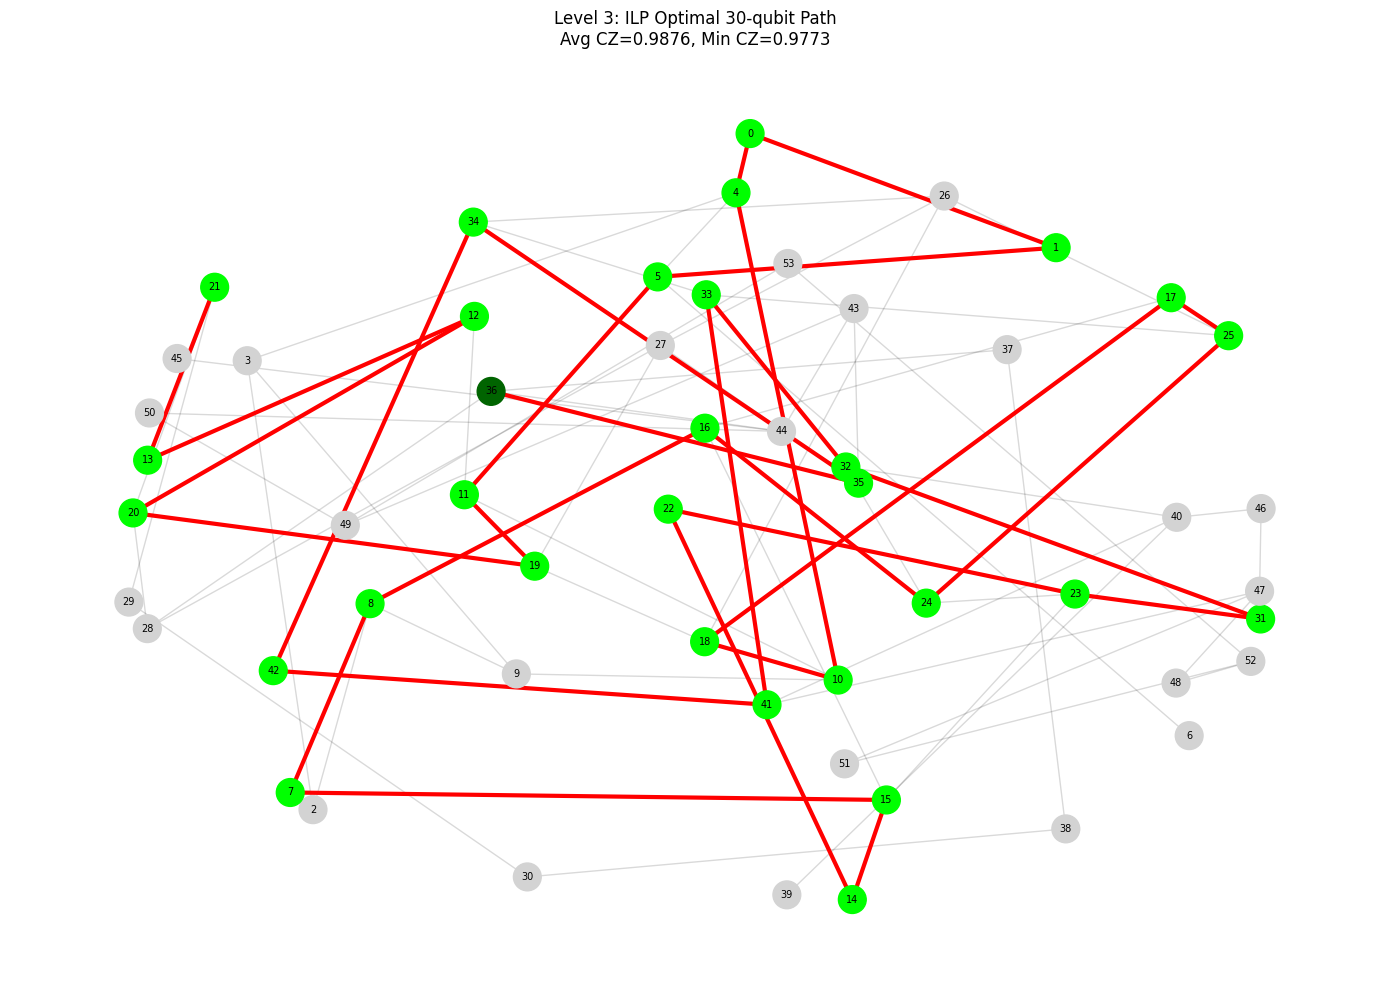

In [9]:
# CELL 10: Visualize Path

plt.figure(figsize=(14, 10))
pos = nx.spring_layout(topology, seed=42, k=2, iterations=100)

nx.draw_networkx_edges(topology, pos, alpha=0.15)

colors = ['lightgray'] * topology.number_of_nodes()
if ilp_path:
    for i, node in enumerate(ilp_path):
        colors[node] = 'lime' if i > 0 else 'darkgreen'
    path_edges = [(ilp_path[i], ilp_path[i+1]) for i in range(len(ilp_path)-1)]
    nx.draw_networkx_edges(topology, pos, edgelist=path_edges,
                           edge_color='red', width=3)

nx.draw_networkx_nodes(topology, pos, node_color=colors, node_size=400)
nx.draw_networkx_labels(topology, pos, font_size=7)

if ilp_path:
    plt.title(f'Level 3: ILP Optimal {N_QUBITS}-qubit Path\n'
              f'Avg CZ={q_ilp["avg_cz"]:.4f}, Min CZ={q_ilp["min_cz"]:.4f}')
plt.axis('off')
plt.tight_layout()
plt.show()

---
## Experiments Below Cost Credits!
---

In [10]:
# CELL 11: Run Experiments

experiments = {
    'ILP optimal':      (qc_ilp_z, qc_ilp_x, ilp_path),
    'Topology DFS':     (qc_topo_z, qc_topo_x, topo_path),
    'Naive auto-route': (qc_naive_z, qc_naive_x, None),
}

all_results = {}

for name, (qc_z_t, qc_x_t, path) in experiments.items():
    print(f"\n{'='*60}")
    print(f"EXPERIMENT: {name}")
    print(f"{'='*60}")

    print("  [1/2] Z-basis...")
    job_z = backend.run(qc_z_t, shots=SHOTS)
    print(f"         Job: {job_z.job_id()}")
    counts_z = job_z.result().get_counts()

    print("  [2/2] X-basis...")
    job_x = backend.run(qc_x_t, shots=SHOTS)
    print(f"         Job: {job_x.job_id()}")
    counts_x = job_x.result().get_counts()

    all_results[name] = {'counts_z': counts_z, 'counts_x': counts_x, 'path': path}

print(f"\nAll experiments done!")


EXPERIMENT: ILP optimal
  [1/2] Z-basis...
         Job: 019c1899-7796-7132-bde0-a49632cf3815


Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

  [2/2] X-basis...
         Job: 019c1899-bf28-7f01-a12a-e2d2bb9ba77a


Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]


EXPERIMENT: Topology DFS
  [1/2] Z-basis...
         Job: 019c1899-fe94-7432-99bb-f5374497024f


Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

  [2/2] X-basis...
         Job: 019c189a-4e44-71f1-97ae-22879d841be3


Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]


EXPERIMENT: Naive auto-route
  [1/2] Z-basis...
         Job: 019c189a-9411-7a90-9380-28e26b5bf099


Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

  [2/2] X-basis...
         Job: 019c189a-e960-7e42-b2e6-306d12a29109


Progress in queue:   0%|          | 0/4 [00:00<?, ?it/s]


All experiments done!


In [12]:
# CELL 12: Results

print(f"{'='*80}")
print(f"RESULTS: {N_QUBITS}-qubit GHZ, {SHOTS} shots")
print(f"{'='*80}")

fidelity_data = {}

for name, data in all_results.items():
    counts_z = data['counts_z']
    counts_x = data['counts_x']
    path = data['path']

    raw = compute_fidelity(counts_z, counts_x, N_QUBITS)

    if path is not None:
        zz_mit, p00_mit, p11_mit = mitigate_zz(counts_z, N_QUBITS, path)
        xx_mit, _ = mitigate_xx(counts_x, N_QUBITS, path)
        f_mit = 0.5 + 0.25 * (zz_mit + xx_mit)
    else:
        f_mit = raw['fidelity']

    fidelity_data[name] = {'raw': raw['fidelity'], 'mitigated': f_mit, 'raw_data': raw}

    print(f"\n--- {name} ---")
    print(f"   P(00...0)  = {raw['p00']:.4f}")
    print(f"   P(11...1)  = {raw['p11']:.4f}")
    print(f"   <ZZ...Z>   = {raw['zz']:.4f}")
    print(f"   <XX...X>   = {raw['xx']:.4f}")
    print(f"   F(raw)     = {raw['fidelity']:.4f}  {'ENTANGLED' if raw['entangled'] else ''}")
    if path is not None:
        print(f"   F(mitigated)= {f_mit:.4f}  {'ENTANGLED' if f_mit > 0.5 else ''}")

print(f"\n{'='*80}")
print(f"COMPARISON")
print(f"{'='*80}")
print(f"{'Method':<25} | {'F(raw)':>10} | {'F(mitigated)':>12}")
print(f"{'-'*55}")
for name, fd in fidelity_data.items():
    print(f"{name:<25} | {fd['raw']:>10.4f} | {fd['mitigated']:>12.4f}")

RESULTS: 30-qubit GHZ, 10000 shots

--- ILP optimal ---
   P(00...0)  = 0.1101
   P(11...1)  = 0.0171
   <ZZ...Z>   = -0.7456
   <XX...X>   = 0.0832
   F(raw)     = 0.3344  
   F(mitigated)= 0.4059  

--- Topology DFS ---
   P(00...0)  = 0.0705
   P(11...1)  = 0.0092
   <ZZ...Z>   = -0.8406
   <XX...X>   = 0.0744
   F(raw)     = 0.3085  
   F(mitigated)= 0.4074  

--- Naive auto-route ---
   P(00...0)  = 0.0584
   P(11...1)  = 0.0087
   <ZZ...Z>   = -0.8658
   <XX...X>   = 0.0932
   F(raw)     = 0.3069  

COMPARISON
Method                    |     F(raw) | F(mitigated)
-------------------------------------------------------
ILP optimal               |     0.3344 |       0.4059
Topology DFS              |     0.3085 |       0.4074
Naive auto-route          |     0.3069 |       0.3069


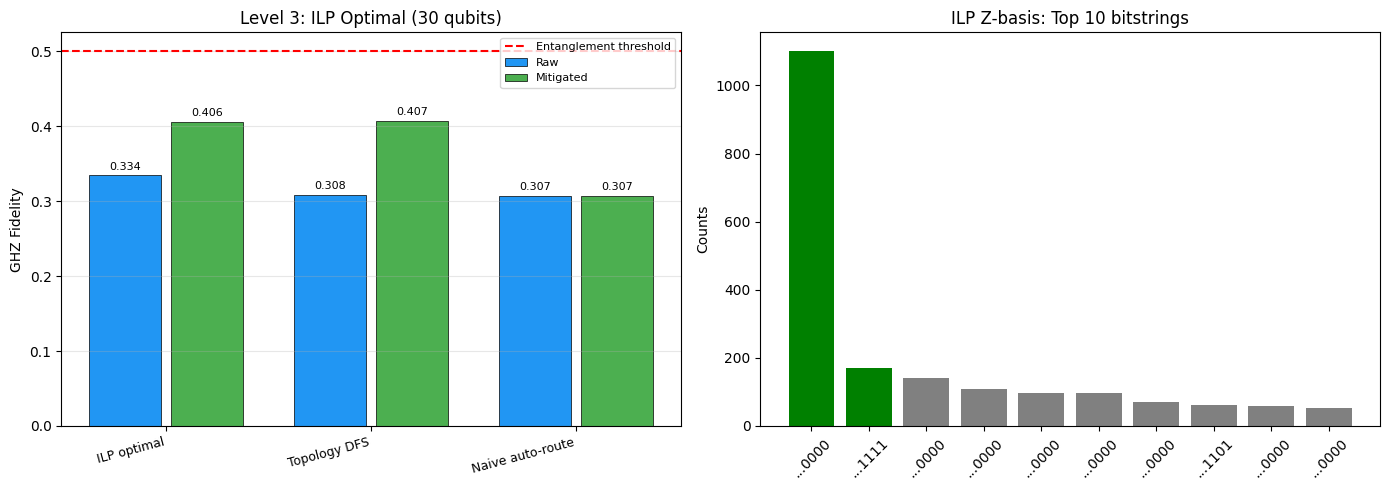

In [13]:
# CELL 13: Visualization

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
names = list(fidelity_data.keys())
raw_vals = [fidelity_data[n]['raw'] for n in names]
mit_vals = [fidelity_data[n]['mitigated'] for n in names]
x = np.arange(len(names))

ax.bar(x - 0.2, raw_vals, 0.35, label='Raw', color='#2196F3', edgecolor='black', linewidth=0.5)
ax.bar(x + 0.2, mit_vals, 0.35, label='Mitigated', color='#4CAF50', edgecolor='black', linewidth=0.5)
ax.axhline(y=0.5, color='red', linestyle='--', label='Entanglement threshold')
ax.set_xticks(x)
ax.set_xticklabels(names, rotation=15, ha='right', fontsize=9)
ax.set_ylabel('GHZ Fidelity')
ax.set_title(f'Level 3: ILP Optimal ({N_QUBITS} qubits)')
ax.legend(fontsize=8)
ax.grid(axis='y', alpha=0.3)

for i, (r, m) in enumerate(zip(raw_vals, mit_vals)):
    ax.text(i - 0.2, r + 0.005, f'{r:.3f}', ha='center', va='bottom', fontsize=8)
    ax.text(i + 0.2, m + 0.005, f'{m:.3f}', ha='center', va='bottom', fontsize=8)

ax2 = axes[1]
counts_z = all_results['ILP optimal']['counts_z']
sorted_c = sorted(counts_z.items(), key=lambda x: x[1], reverse=True)[:10]
labels = [f'...{s[-4:]}' for s, _ in sorted_c]
values = [c for _, c in sorted_c]
bar_colors = ['green' if s in ['0'*N_QUBITS, '1'*N_QUBITS] else 'gray' for s, _ in sorted_c]
ax2.bar(range(len(labels)), values, color=bar_colors)
ax2.set_xticks(range(len(labels)))
ax2.set_xticklabels(labels, rotation=45)
ax2.set_ylabel('Counts')
ax2.set_title('ILP Z-basis: Top 10 bitstrings')

plt.tight_layout()
plt.show()

## Summary: Level 3 - ILP Optimal

### Method
Formulated the GHZ chain mapping as an Integer Linear Program:

$$\max \sum_{i,k} x_{i,k} \cdot \log F_{RO}(i) + \sum_{i,j,k} y_{i,j,k} \cdot \log F_{CZ}(i,j)$$

subject to:
- One qubit per position, one position per qubit
- Adjacent positions must be physically connected
- $y_{i,j,k} = x_{i,k} \cdot x_{j,k+1}$ (linearized)

Solved with PuLP/CBC.

### GHZ Fidelity Witness
$$F_{GHZ} = \frac{1}{2} + \frac{1}{4}(\langle ZZ\cdots Z \rangle + \langle XX\cdots X \rangle)$$

If $F > 0.5$: entanglement proven.

### Pros
- **Provably optimal**: finds the single best linear chain on the hardware
- Considers all qubits and all edges simultaneously
- No heuristic approximations

### Cons
- Solver runtime grows with problem size (54 qubits is manageable,
  but very large chips could be slow)
- Requires `pulp` dependency
- Solution is optimal for the given objective (log-fidelity product),
  which is a proxy for actual GHZ fidelity